(49, 49, 3)


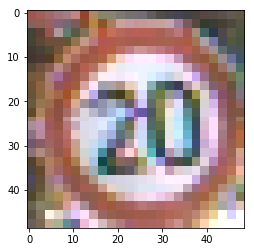

(49, 49, 3)


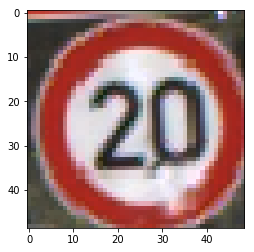

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import csv, time, os.path
from six.moves import cPickle
from sklearn import model_selection as ms

# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath, size, training=True):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 43 classes
    if training:
        for c in range(0,43):
            prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
            gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
            gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
            gtReader.next() # skip header
            # loop over all images in current annotations file
            for row in gtReader:
#                 image = Image.open(prefix + row[0]).convert('L') # Load an image and convert to grayscale
                image = Image.open(prefix + row[0])
                box = (int(row[3]), int(row[4]), int(row[5]), int(row[6])) # Specify ROI box
                image = image.crop(box) # Crop the ROI
                image = image.resize(size) # Resize images
                images.append(np.asarray(image).astype('uint8')) # the 1th column is the filename, while 3,4,5,6 are the vertices of ROI
                labels.append(int(row[7])) # the 8th column is the label
            gtFile.close()
    else:
        gtFile = open(rootpath + "/../../GT-final_test.csv") # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        gtReader.next() # skip header
        # loop over all images in current annotations file
        for row in gtReader:
#             image = Image.open(rootpath + '/' + row[0]).convert('L') # Load an image and convert to grayscale
            image = Image.open(rootpath + '/' + row[0]) # Color version
            box = (int(row[3]), int(row[4]), int(row[5]), int(row[6])) # Specify ROI box
            image = image.crop(box) # Crop the ROI
            image = image.resize(size) # Resize images
            images.append(np.asarray(image).astype('uint8')) # the 1th column is the filename, while 3,4,5,6 are the vertices of ROI
            labels.append(int(row[7])) # the 8th column is the label
        gtFile.close()
        
    return images, labels

root = "/Users/moderato/Downloads/GTSRB/try"
train_dir = root + "/Final_Training/Images"
test_dir = root + "/Final_Test/Images"
resize_size = (49, 49)
epoch_num = 60

trainImages, trainLabels, testImages, testLabels = None, None, None, None

## If pickle file exists, read the file
if os.path.isfile(root + "/processed_images.pkl"):
    f = open(root + "/processed_images.pkl", 'rb')
    trainImages = cPickle.load(f, encoding="latin1")
    trainLabels = cPickle.load(f, encoding="latin1")
    testImages = cPickle.load(f, encoding="latin1")
    testLabels = cPickle.load(f, encoding="latin1")
    f.close()
## Else, read images and write to the pickle file
else:
    start = time.time()
    trainImages, trainLabels = readTrafficSigns(train_dir, resize_size)
    print("Training Image preprocessing finished in {:.2f} seconds".format(time.time() - start))
    print("trainImages list length %d, trainLabels list length {:d}".format(len(trainImages), len(trainLabels)))

    start = time.time()
    testImages, testLabels = readTrafficSigns(test_dir, resize_size, False)
    print("Testing Image preprocessing finished in {:.2f} seconds".format(time.time() - start))
    print("testImages list length {:d}, testLabels list length {:d}".format(len(testImages), len(testLabels)))
    
    f = open(root + "/processed_images.pkl", 'wb')
    for obj in [trainImages, trainLabels, testImages, testLabels]:
        cPickle.dump(obj, f, protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()
    
print(trainImages[42].shape)
plt.imshow(trainImages[42])
plt.show()

print(testImages[21].shape)
plt.imshow(trainImages[21])
plt.show()

x_train, x_valid, y_train, y_valid = ms.train_test_split(trainImages, trainLabels, test_size=0.2, random_state=542)

## MxNet

In [2]:
import mxnet as mx
import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout

epoch_num = 1
batch_size = 128
resize_size = (49, 49)

In [3]:
mx_train_x = mx.nd.array([i.swapaxes(0,2).astype("float32")/255 for i in x_train])
mx_valid_x = mx.nd.array([i.swapaxes(0,2).astype("float32")/255 for i in x_valid])
mx_test_x = mx.nd.array([i.swapaxes(0,2).astype("float32")/255 for i in testImages])
mx_train_y = mx.nd.array(y_train, dtype=np.float32) # No need of one_hot
mx_valid_y = mx.nd.array(y_valid, dtype=np.float32)
mx_test_y = mx.nd.array(testLabels, dtype=np.float32)

In [4]:
# The iterators have input name of 'data' and output name of 'softmax_label' if not particularly specified
mx_train_set = mx.io.NDArrayIter(mx_train_x, mx_train_y, batch_size, shuffle=True)
mx_valid_set = mx.io.NDArrayIter(mx_valid_x, mx_valid_y, batch_size)
mx_test_set = mx.io.NDArrayIter(mx_test_x, mx_test_y, batch_size)

# Print the shape and type of training set lapel
# mx_train_set.provide_label

In [5]:
data = mx.sym.Variable('data')
mx_conv1 = mx.sym.Convolution(data = data, name='mx_conv1', num_filter=64, kernel=(5,5), stride=(2,2))
mx_act1 = mx.sym.Activation(data = mx_conv1, name='mx_relu1', act_type="relu")
mx_mp1 = mx.sym.Pooling(data = mx_act1, name = 'mx_pool1', kernel=(2,2), stride=(2,2), pool_type='max')
mx_conv2 = mx.sym.Convolution(data = mx_mp1, name='mx_conv2', num_filter=512, kernel=(3,3), stride=(1,1), pad=(1,1))
mx_act2 = mx.sym.Activation(data = mx_conv2, name='mx_relu2', act_type="relu")
mx_mp2 = mx.sym.Pooling(data = mx_act2, name = 'mx_pool2', kernel=(2,2), stride=(2,2), pool_type='max')
mx_fl = mx.sym.Flatten(data = mx_mp2, name="mx_flatten")
mx_fc1 = mx.sym.FullyConnected(data = mx_fl, name='mx_fc1', num_hidden=2048)
mx_drop = mx.sym.Dropout(data = mx_fc1, name='mx_dropout', p=0.5)
mx_fc2 = mx.sym.FullyConnected(data = mx_drop, name='mx_fc2', num_hidden=43)
mx_softmax = mx.sym.SoftmaxOutput(data = mx_fc2, name ='softmax')

# Print the names of arguments in the model
# mx_softmax.list_arguments() # Make sure the input and the output names are consistent of those in the iterator!!

# Print the size of the model
# mx_softmax.infer_shape(data=(1,3,49,49))

# Draw the network
# mx.viz.plot_network(mx_softmax, shape={"data":(batch_size, 3, resize_size[0], resize_size[1])})

In [13]:
class MxCustomInit(mx.initializer.Initializer):
    def __init__(self, idict):
        super(MxCustomInit, self).__init__()
        self.dict = idict
        np.random.seed(seed=542)

    def _init_weight(self, name, arr):
        if name in self.dict.keys():
            dictPara = self.dict[name]
            for(k, v) in dictPara.items():
                arr = np.random.normal(0, v, size=arr.shape)

    def _init_bias(self, name, arr):
        if name in self.dict.keys():
            dictPara = self.dict[name]
            for(k, v) in dictPara.items():
                arr[:] = v

In [14]:
mx_optimizer = mx.optimizer.SGD(learning_rate = 0.001, momentum = 0.9)
mx_nor_dict = {'normal': 0.01}
mx_cons_dict = {'constant': 0.0}
mx_init_dict = {}
for layer in mx_softmax.list_arguments():
    hh = layer.split('_')
    if hh[-1] == 'weight':
        mx_init_dict[layer] = mx_nor_dict
    elif hh[-1] == 'bias':
        mx_init_dict[layer] = mx_cons_dict
# print(mx_init_dict)

In [15]:
# create a trainable module on CPU
mx_model = mx.mod.Module(context = mx.cpu(), symbol = mx_softmax)

# Currently no solution to reproducibility. Eyes on issue 47.
mx_model.fit(mx_train_set, # train data
             eval_data = mx_valid_set, # validation data
             num_epoch = epoch_num,
             initializer = MxCustomInit(mx_init_dict),
             optimizer = 'sgd',
             optimizer_params = {'learning_rate': 0.01, 'momentum': 0.9},
             force_rebind=True,
             force_init=True,
             eval_metric ='acc', # report accuracy during training
             batch_end_callback = mx.callback.Speedometer(batch_size, 10)) # output progress for each 10 data batches

INFO:root:Epoch[0] Batch [10]	Speed: 191.79 samples/sec	accuracy=0.051847
INFO:root:Epoch[0] Batch [20]	Speed: 192.70 samples/sec	accuracy=0.057031
INFO:root:Epoch[0] Batch [30]	Speed: 201.01 samples/sec	accuracy=0.049219
INFO:root:Epoch[0] Batch [40]	Speed: 204.48 samples/sec	accuracy=0.058594
INFO:root:Epoch[0] Batch [50]	Speed: 199.70 samples/sec	accuracy=0.060156
INFO:root:Epoch[0] Batch [60]	Speed: 200.07 samples/sec	accuracy=0.058594
INFO:root:Epoch[0] Batch [70]	Speed: 200.78 samples/sec	accuracy=0.052344
INFO:root:Epoch[0] Batch [80]	Speed: 203.52 samples/sec	accuracy=0.047656
INFO:root:Epoch[0] Batch [90]	Speed: 198.44 samples/sec	accuracy=0.060937
INFO:root:Epoch[0] Batch [100]	Speed: 204.94 samples/sec	accuracy=0.042969
INFO:root:Epoch[0] Batch [110]	Speed: 200.59 samples/sec	accuracy=0.053125
INFO:root:Epoch[0] Batch [120]	Speed: 206.61 samples/sec	accuracy=0.055469
INFO:root:Epoch[0] Batch [130]	Speed: 206.37 samples/sec	accuracy=0.050781
INFO:root:Epoch[0] Batch [140]	Spe

In [9]:
score = mx_model.score(mx_test_set, ['acc'])
print("Accuracy score is %f" % (score[0][1]))

Accuracy score is 0.059265
